In [1]:
import json
from collections import defaultdict, Counter
import numpy as np
from os import listdir
import matplotlib.pyplot as plt
import scipy.stats as stats
import gzip
import scipy.sparse as sparse
import statsmodels.api as sm
import random
from sklearn.metrics import precision_recall_curve, roc_curve
from itertools import combinations, product
import matplotlib
import csv
import cvxpy as cp

In [274]:
# There shouldn't be any correlation between short arms of acrocentric chromosomes

#phase_dir = '../recomb_ihart.ms2'
#ped_file = '../../DATA/ihart.ms2/ihart.ped.quads.ped'

phase_dir = '../recomb_spark'
ped_file = '../../DATA/spark/sparkfam.ped.quads.ped'

acrocentric_chroms = ['chr13', 'chr14', 'chr15', 'chr21', 'chr22']
#acrocentric_chroms = ['chr%d' % x for x in range(1, 23)] + ['chrX', 'chrY']

In [275]:
# pull affected status
# (0=unknown; 1=unaffected; 2=affected)
child_id_to_affected = dict()
child_id_to_sex = dict()
with open(ped_file, 'r') as f:
    for line in f:
        pieces = line.strip().split('\t')
        if len(pieces) >= 6:
            fam_id, child_id, f_id, m_id, sex, disease_status = pieces[0:6]
            if 'ssc' in ped_file:
                child_id = child_id.replace('.', '_')
            child_id_to_affected[child_id] = disease_status
            child_id_to_sex[child_id] = sex


print('ped loaded')
print('children', len(child_id_to_affected))




ped loaded
children 13244


In [276]:
# start by pulling short arm region

chrom_to_short_arm_coords = dict()
chrom_to_long_arm_coords = dict()

with open('../data/cytoBand38.txt', 'r') as f:
    header = next(f).strip().split()
    
    current_chrom = None
    prev_region = None
    prev_region_end = None
    p_q_transition = None
    for line in f:
        pieces = line.strip().split()
        
        if current_chrom != pieces[0]:
            if p_q_transition is not None:
                chrom_to_long_arm_coords[current_chrom] = (p_q_transition, prev_region_end)
            current_chrom = pieces[0]
            prev_region = None
            prev_region_end = None
            p_q_transition = None
            
        if prev_region is not None and prev_region.startswith('p') and pieces[3].startswith('q'):
            p_q_transition = prev_region_end
            chrom_to_short_arm_coords[current_chrom] = (1, p_q_transition)
        prev_region, prev_region_end = pieces[3], int(pieces[2])
        
print(chrom_to_short_arm_coords)
print(chrom_to_long_arm_coords)

{'chr1': (1, 123400000), 'chr2': (1, 93900000), 'chr3': (1, 90900000), 'chr4': (1, 50000000), 'chr5': (1, 48800000), 'chr6': (1, 59800000), 'chr7': (1, 60100000), 'chr8': (1, 45200000), 'chr9': (1, 43000000), 'chrX': (1, 61000000), 'chrY': (1, 10400000), 'chr10': (1, 39800000), 'chr11': (1, 53400000), 'chr12': (1, 35500000), 'chr13': (1, 17700000), 'chr14': (1, 17200000), 'chr15': (1, 19000000), 'chr16': (1, 36800000), 'chr17': (1, 25100000), 'chr18': (1, 18500000), 'chr19': (1, 26200000), 'chr20': (1, 28100000), 'chr21': (1, 12000000), 'chr22': (1, 15000000)}
{'chr1': (123400000, 248956422), 'chr2': (93900000, 242193529), 'chr3': (90900000, 198295559), 'chr4': (50000000, 190214555), 'chr5': (48800000, 181538259), 'chr6': (59800000, 170805979), 'chr7': (60100000, 159345973), 'chr8': (45200000, 145138636), 'chr9': (43000000, 138394717), 'chrX': (61000000, 156040895), 'chrY': (10400000, 57227415), 'chr10': (39800000, 133797422), 'chr11': (53400000, 135086622), 'chr12': (35500000, 1332753

In [277]:
with open('%s/sibpairs.json' % phase_dir, 'r') as f:
    sibpairs = json.load(f)
print(len(sibpairs))

6925


In [278]:
chrom_to_shortarm_positions = defaultdict(list)
for chrom in acrocentric_chroms:
    for i in range(50):
        try:
            x = np.load('../../DATA/ihart.ms2/genotypes/chr.%s.%d.gen.coordinates.npy' % (chrom[3:], i))
            arm_start, arm_end = chrom_to_short_arm_coords[chrom]
            chrom_to_shortarm_positions[chrom].extend(x[x[:, 1]<=arm_end, 1])
        except:
            pass
    chrom_to_shortarm_positions[chrom] = np.array(chrom_to_shortarm_positions[chrom])
    
print([(k, len(v)) for k, v in chrom_to_shortarm_positions.items()])

[('chr13', 436564), ('chr14', 10224), ('chr15', 42846), ('chr21', 278970), ('chr22', 172942)]


In [279]:
is_aff_aff = np.array([child_id_to_affected[x['sibling1']]=='2' and child_id_to_affected[x['sibling2']]=='2' for x in sibpairs])
is_aff_nt = np.array([(child_id_to_affected[x['sibling1']]=='1' and child_id_to_affected[x['sibling2']]=='2') or (child_id_to_affected[x['sibling1']]=='2' and child_id_to_affected[x['sibling2']]=='1') for x in sibpairs])
is_nt_nt = np.array([child_id_to_affected[x['sibling1']]=='1' and child_id_to_affected[x['sibling2']]=='1' for x in sibpairs])



In [280]:
# sibpair, chrom, mat/pat, no ibd/ibd
acrocentric_ibd = np.zeros((len(sibpairs), len(acrocentric_chroms), 2, 2))
for i, sibpair in enumerate(sibpairs):
    print(sibpair['family'])
    with open('../%s/%s.phased.txt' % (sibpair['phase_dir'], sibpair['family']), 'r') as f:
        for line in f:
            pieces = line.strip().split('\t')
            # we're in an acrocentric chromosome, and it's not a hard to sequence region
            if pieces[0] in acrocentric_chroms:
                arm_start, arm_end = chrom_to_short_arm_coords[pieces[0]]
                interval_start, interval_end = int(pieces[-2]), int(pieces[-1])
                overlap = min(arm_end, interval_end) - max(arm_start, interval_start)
                
                if overlap>0:
                    if pieces[11]=='1':
                        # mat no IBD
                        acrocentric_ibd[i, acrocentric_chroms.index(pieces[0]), 0, 0] += overlap
                    elif pieces[11]=='0':
                        # mat IBD
                        acrocentric_ibd[i, acrocentric_chroms.index(pieces[0]), 0, 1] += overlap
                    
                    if pieces[12]=='3':
                        # pat no IBD
                        acrocentric_ibd[i, acrocentric_chroms.index(pieces[0]), 1, 0] += overlap
                    elif pieces[12]=='2':
                        # pat IBD
                        acrocentric_ibd[i, acrocentric_chroms.index(pieces[0]), 1, 1] += overlap

SF0000027.SP0000027.SP0000034
SF0000027.SP0000027.SP0000063
SF0000027.SP0000034.SP0000063
SF0000145.SP0000145.SP0001673
SF0000226.SP0000226.SP0000285
SF0000267.SP0000267.SP0001200
SF0000300.SP0000300.SP0000447
SF0000300.SP0000300.SP0000734
SF0000300.SP0000447.SP0000734
SF0000301.SP0000301.SP0000760
SF0000362.SP0000362.SP0000523
SF0000463.SP0000463.SP0000533
SF0000551.SP0000551.SP0001640
SF0000834.SP0000967.SP0001066
SF0000938.SP0000938.SP0000996
SF0000974.SP0000974.SP0001012
SF0001135.SP0001135.SP0010098
SF0001493.SP0001493.SP0001546
SF0001506.SP0001506.SP0001527
SF0001591.SP0001591.SP0001626
SF0001660.SP0001660.SP0001692
SF0001752.SP0001752.SP0002136
SF0001753.SP0001753.SP0006937
SF0001948.SP0001948.SP0001983
SF0002124.SP0002124.SP0002157
SF0002252.SP0002252.SP0002281
SF0002517.SP0002517.SP0002547
SF0002519.SP0002519.SP0002552
SF0002542.SP0002542.SP0002655
SF0002634.SP0002634.SP0002667
SF0002676.SP0002676.SP0002706
SF0002835.SP0002835.SP0003933
SF0003127.SP0003127.SP0003156
SF0003127.

SF0012602.SP0012641.SP0022006
SF0012602.SP0021929.SP0021938
SF0012602.SP0021929.SP0021991
SF0012602.SP0021929.SP0022006
SF0012602.SP0021938.SP0021991
SF0012602.SP0021938.SP0022006
SF0012602.SP0021991.SP0022006
SF0012645.SP0012645.SP0012682
SF0012667.SP0012667.SP0012703
SF0012697.SP0012697.SP0012769
SF0012713.SP0012713.SP0012746
SF0012713.SP0012713.SP0012781
SF0012713.SP0012746.SP0012781
SF0012774.SP0012774.SP0012913
SF0012778.SP0012778.SP0012813
SF0012883.SP0012721.SP0012883
SF0012890.SP0012890.SP0012896
SF0012926.SP0012926.SP0012958
SF0013001.SP0013001.SP0022247
SF0013015.SP0013015.SP0013044
SF0013041.SP0013041.SP0013084
SF0013065.SP0013065.SP0013079
SF0013077.SP0013077.SP0013080
SF0013152.SP0013138.SP0013152
SF0013161.SP0013161.SP0013254
SF0013195.SP0013194.SP0013195
SF0013216.SP0013216.SP0013242
SF0013320.SP0013320.SP0013321
SF0013380.SP0013377.SP0013380
SF0013526.SP0013526.SP0013799
SF0013534.SP0013534.SP0013595
SF0013537.SP0013537.SP0013568
SF0013601.SP0013601.SP0013798
SF0013605.

SF0025548.SP0025575.SP0025637
SF0025548.SP0025609.SP0025637
SF0025563.SP0025563.SP0025586
SF0025581.SP0025581.SP0025647
SF0025795.SP0025795.SP0025830
SF0025807.SP0025807.SP0025840
SF0025853.SP0025853.SP0025908
SF0025863.SP0025863.SP0025977
SF0025927.SP0025927.SP0025981
SF0025959.SP0025959.SP0025986
SF0025964.SP0025964.SP0025965
SF0026012.SP0026012.SP0026044
SF0026012.SP0026012.SP0026075
SF0026012.SP0026044.SP0026075
SF0026064.SP0026064.SP0026090
SF0026069.SP0026069.SP0026097
SF0026161.SP0026161.SP0026184
SF0026167.SP0026167.SP0026199
SF0026167.SP0026167.SP0026234
SF0026167.SP0026199.SP0026234
SF0026173.SP0026173.SP0026200
SF0026196.SP0026196.SP0026232
SF0026235.SP0026235.SP0026252
SF0026256.SP0026256.SP0026307
SF0026282.SP0026282.SP0026292
SF0026295.SP0026280.SP0026295
SF0026304.SP0026304.SP0026345
SF0026358.SP0026358.SP0026413
SF0026360.SP0026360.SP0026392
SF0026424.SP0026424.SP0026472
SF0026428.SP0026428.SP0026474
SF0026428.SP0026428.SP0084320
SF0026428.SP0026474.SP0084320
SF0026446.

SF0036103.SP0036103.SP0036105
SF0036128.SP0036128.SP0036130
SF0036172.SP0036172.SP0036173
SF0036212.SP0036212.SP0036213
SF0036240.SP0036240.SP0036241
SF0036335.SP0036335.SP0036336
SF0036440.SP0036440.SP0036441
SF0036521.SP0036521.SP0036522
SF0036529.SP0036529.SP0036530
SF0036529.SP0036529.SP0036531
SF0036529.SP0036529.SP0036532
SF0036529.SP0036530.SP0036531
SF0036529.SP0036530.SP0036532
SF0036560.SP0036560.SP0036561
SF0036574.SP0036574.SP0036575
SF0036587.SP0036587.SP0036589
SF0036642.SP0036642.SP0036643
SF0036681.SP0036681.SP0036682
SF0036733.SP0036733.SP0036734
SF0036749.SP0036749.SP0036750
SF0036774.SP0036774.SP0036775
SF0036828.SP0036828.SP0036829
SF0036847.SP0036847.SP0036848
SF0036869.SP0036869.SP0036870
SF0036888.SP0036888.SP0036889
SF0036888.SP0036888.SP0036890
SF0036888.SP0036889.SP0036890
SF0036982.SP0036982.SP0036983
SF0036987.SP0036987.SP0036988
SF0036987.SP0036987.SP0036989
SF0036987.SP0036988.SP0036989
SF0036994.SP0036994.SP0036995
SF0037007.SP0037007.SP0037008
SF0037039.

SF0046605.SP0046605.SP0046608
SF0046605.SP0046607.SP0046608
SF0046621.SP0046621.SP0046622
SF0046628.SP0046628.SP0046629
SF0046707.SP0046707.SP0046708
SF0046784.SP0046784.SP0046785
SF0046788.SP0046788.SP0046789
SF0046788.SP0046788.SP0046791
SF0046788.SP0046789.SP0046791
SF0046838.SP0046838.SP0046839
SF0046890.SP0046890.SP0046891
SF0046927.SP0046927.SP0046928
SF0046961.SP0046961.SP0046962
SF0047040.SP0047040.SP0047041
SF0047060.SP0047060.SP0047064
SF0047102.SP0047102.SP0047105
SF0047137.SP0047137.SP0047138
SF0047209.SP0047209.SP0047210
SF0047225.SP0047225.SP0047226
SF0047294.SP0047294.SP0047295
SF0047301.SP0047301.SP0047302
SF0047317.SP0047317.SP0047318
SF0047380.SP0047380.SP0047381
SF0047388.SP0047388.SP0047389
SF0047431.SP0047431.SP0047432
SF0047475.SP0047475.SP0047476
SF0047497.SP0047497.SP0047498
SF0047516.SP0047516.SP0047517
SF0047593.SP0047593.SP0047595
SF0047609.SP0047609.SP0047610
SF0047621.SP0047621.SP0047622
SF0047725.SP0047725.SP0047726
SF0047799.SP0047799.SP0047800
SF0047819.

SF0056339.SP0056339.SP0056348
SF0056363.SP0056363.SP0056366
SF0056414.SP0056414.SP0056415
SF0056427.SP0056427.SP0056430
SF0056461.SP0056461.SP0056464
SF0056467.SP0056467.SP0056469
SF0056528.SP0056528.SP0056531
SF0056567.SP0056567.SP0056569
SF0056609.SP0056609.SP0056612
SF0056650.SP0056650.SP0056651
SF0056650.SP0056650.SP0056652
SF0056650.SP0056650.SP0056653
SF0056650.SP0056651.SP0056652
SF0056650.SP0056651.SP0056653
SF0056650.SP0056652.SP0056653
SF0056681.SP0056681.SP0056682
SF0056705.SP0056705.SP0056706
SF0056725.SP0056725.SP0056735
SF0056731.SP0056731.SP0056733
SF0056742.SP0056742.SP0056744
SF0056753.SP0056753.SP0056755
SF0056870.SP0056870.SP0056873
SF0056881.SP0056881.SP0056882
SF0056894.SP0056894.SP0056902
SF0056899.SP0056899.SP0056904
SF0056918.SP0056918.SP0056921
SF0056920.SP0056920.SP0056922
SF0056923.SP0056923.SP0056930
SF0056976.SP0056976.SP0056978
SF0056990.SP0056990.SP0056991
SF0056995.SP0056995.SP0056997
SF0057000.SP0057000.SP0057002
SF0057026.SP0057026.SP0057029
SF0057061.

SF0066097.SP0066097.SP0066098
SF0066211.SP0066211.SP0066212
SF0066218.SP0066218.SP0066220
SF0066286.SP0066286.SP0066287
SF0066294.SP0066294.SP0066295
SF0066342.SP0066342.SP0066343
SF0066342.SP0066342.SP0066345
SF0066342.SP0066342.SP0066346
SF0066342.SP0066343.SP0066345
SF0066342.SP0066343.SP0066346
SF0066342.SP0066345.SP0066346
SF0066376.SP0066376.SP0066377
SF0066425.SP0066425.SP0066426
SF0066430.SP0066430.SP0066432
SF0066532.SP0066532.SP0066533
SF0066545.SP0066545.SP0066546
SF0066747.SP0066747.SP0066748
SF0066836.SP0066836.SP0066837
SF0066842.SP0066842.SP0066843
SF0066844.SP0066844.SP0066845
SF0066876.SP0066876.SP0066877
SF0066900.SP0066900.SP0066903
SF0066907.SP0066907.SP0066908
SF0066932.SP0066932.SP0066933
SF0066983.SP0066983.SP0066984
SF0066994.SP0066994.SP0066996
SF0067000.SP0067000.SP0067001
SF0067018.SP0067018.SP0067019
SF0067018.SP0067018.SP0067020
SF0067018.SP0067018.SP0067021
SF0067018.SP0067019.SP0067020
SF0067018.SP0067019.SP0067021
SF0067018.SP0067020.SP0067021
SF0067077.

SF0077172.SP0077172.SP0077173
SF0077180.SP0077180.SP0077181
SF0077254.SP0077254.SP0077255
SF0077270.SP0077270.SP0077271
SF0077342.SP0077342.SP0077344
SF0077387.SP0077387.SP0077388
SF0077387.SP0077387.SP0077389
SF0077387.SP0077388.SP0077389
SF0077401.SP0077401.SP0077402
SF0077401.SP0077401.SP0077403
SF0077401.SP0077402.SP0077403
SF0077415.SP0077415.SP0077417
SF0077443.SP0077443.SP0077444
SF0077459.SP0077459.SP0077461
SF0077463.SP0077463.SP0077464
SF0077565.SP0077565.SP0077567
SF0077617.SP0077617.SP0077618
SF0077634.SP0077634.SP0077635
SF0077668.SP0077668.SP0077669
SF0077711.SP0077711.SP0077712
SF0077711.SP0077711.SP0077715
SF0077711.SP0077711.SP0077716
SF0077711.SP0077712.SP0077715
SF0077711.SP0077712.SP0077716
SF0077711.SP0077715.SP0077716
SF0077733.SP0077733.SP0077734
SF0077774.SP0077774.SP0077776
SF0077777.SP0077777.SP0077778
SF0077788.SP0077788.SP0077789
SF0077792.SP0077792.SP0077793
SF0077915.SP0077915.SP0077916
SF0077930.SP0077930.SP0077931
SF0077930.SP0077930.SP0077932
SF0077930.

SF0089272.SP0089272.SP0089273
SF0089302.SP0089302.SP0089304
SF0089372.SP0089372.SP0089373
SF0089505.SP0089505.SP0089506
SF0089892.SP0089892.SP0089893
SF0089919.SP0089919.SP0089920
SF0089962.SP0089962.SP0089963
SF0090019.SP0090019.SP0090020
SF0090089.SP0090089.SP0090091
SF0090119.SP0090119.SP0090120
SF0090223.SP0090223.SP0090225
SF0090228.SP0090228.SP0090229
SF0090443.SP0090443.SP0090444
SF0090599.SP0090599.SP0090600
SF0090611.SP0090611.SP0090613
SF0090686.SP0090686.SP0090687
SF0090691.SP0090691.SP0090692
SF0090702.SP0090702.SP0090703
SF0090779.SP0090779.SP0090781
SF0090797.SP0090797.SP0090798
SF0090839.SP0090839.SP0090840
SF0090965.SP0090965.SP0090966
SF0090984.SP0090984.SP0090985
SF0091119.SP0091119.SP0091120
SF0091137.SP0091137.SP0091139
SF0091173.SP0091173.SP0091175
SF0091184.SP0091184.SP0091185
SF0091354.SP0091354.SP0091355
SF0091359.SP0091359.SP0091360
SF0091370.SP0091370.SP0091371
SF0091391.SP0091391.SP0091392
SF0091413.SP0091413.SP0091415
SF0091434.SP0091434.SP0091435
SF0091494.

SF0104732.SP0104733.SP0104735
SF0104732.SP0104734.SP0104735
SF0104743.SP0104743.SP0104744
SF0104915.SP0104915.SP0104918
SF0104999.SP0104999.SP0105000
SF0105003.SP0105003.SP0105004
SF0105069.SP0105069.SP0105071
SF0105081.SP0105081.SP0105082
SF0105098.SP0105098.SP0105103
SF0105120.SP0105120.SP0105121
SF0105442.SP0105442.SP0105443
SF0105483.SP0105483.SP0105484
SF0105547.SP0105547.SP0105548
SF0105624.SP0105624.SP0105625
SF0105909.SP0105909.SP0105911
SF0106019.SP0106019.SP0106020
SF0106136.SP0106136.SP0106137
SF0106153.SP0106153.SP0106154
SF0106214.SP0106214.SP0106215
SF0106231.SP0106231.SP0106234
SF0106253.SP0106253.SP0106254
SF0106290.SP0106290.SP0106292
SF0106317.SP0106317.SP0106318
SF0106346.SP0106346.SP0106347
SF0106388.SP0106388.SP0106389
SF0106388.SP0106388.SP0106391
SF0106388.SP0106389.SP0106391
SF0106496.SP0106496.SP0106497
SF0106496.SP0106496.SP0106498
SF0106496.SP0106497.SP0106498
SF0106518.SP0106518.SP0106519
SF0106553.SP0106553.SP0106554
SF0106656.SP0106656.SP0106657
SF0106784.

SF0126138.SP0126138.SP0126139
SF0126154.SP0126154.SP0126155
SF0126236.SP0126236.SP0126237
SF0126288.SP0126288.SP0126289
SF0126437.SP0126437.SP0126438
SF0126437.SP0126437.SP0126439
SF0126437.SP0126438.SP0126439
SF0126572.SP0126572.SP0126573
SF0126620.SP0126620.SP0126621
SF0126620.SP0126620.SP0126622
SF0126620.SP0126621.SP0126622
SF0126626.SP0126626.SP0126627
SF0126635.SP0126635.SP0126637
SF0126636.SP0126636.SP0126638
SF0126686.SP0126686.SP0126688
SF0126692.SP0126692.SP0126693
SF0126749.SP0126749.SP0126750
SF0126771.SP0126771.SP0126772
SF0126771.SP0126771.SP0126775
SF0126771.SP0126772.SP0126775
SF0126805.SP0126805.SP0126807
SF0126876.SP0126876.SP0126877
SF0126886.SP0126886.SP0126887
SF0126895.SP0126895.SP0126896
SF0126961.SP0126961.SP0126962
SF0127097.SP0127097.SP0127098
SF0127237.SP0127237.SP0127238
SF0127237.SP0127237.SP0127239
SF0127237.SP0127238.SP0127239
SF0127250.SP0127250.SP0127252
SF0127501.SP0127501.SP0127502
SF0127522.SP0127522.SP0129743
SF0127620.SP0127620.SP0127621
SF0127719.

SF0148872.SP0148873.SP0148875
SF0148872.SP0148874.SP0148875
SF0149685.SP0149685.SP0149686
SF0149957.SP0149957.SP0149958
SF0149989.SP0149989.SP0149991
SF0149994.SP0149994.SP0149995
SF0150010.SP0150010.SP0150011
SF0150010.SP0150010.SP0150012
SF0150010.SP0150010.SP0150014
SF0150010.SP0150011.SP0150012
SF0150010.SP0150011.SP0150014
SF0150010.SP0150012.SP0150014
SF0150040.SP0150040.SP0150044
SF0150569.SP0150569.SP0150570
SF0151010.SP0151010.SP0151012
SF0151010.SP0151010.SP0151014
SF0151010.SP0151010.SP0151015
SF0151010.SP0151010.SP0151016
SF0151010.SP0151012.SP0151014
SF0151010.SP0151012.SP0151015
SF0151010.SP0151012.SP0151016
SF0151010.SP0151014.SP0151015
SF0151010.SP0151014.SP0151016
SF0151010.SP0151015.SP0151016
SF0151550.SP0151550.SP0151551
SF0152533.SP0152533.SP0152534
SF0152806.SP0152806.SP0152808
SF0152806.SP0152807.SP0152808
SF0152979.SP0152979.SP0152981
SF0154149.SP0154149.SP0154150
SF0154208.SP0154208.SP0154209
SF0004546.SP0004546.SP0004648
SF0004636.SP0004636.SP0024370
SF0006442.

SF0166377.SP0166377.SP0166378
SF0166883.SP0166883.SP0166884
SF0166900.SP0166900.SP0166902
SF0166900.SP0166900.SP0166904
SF0166900.SP0166900.SP0166905
SF0166900.SP0166902.SP0166904
SF0166900.SP0166902.SP0166905
SF0166900.SP0166904.SP0166905
SF0167016.SP0167016.SP0167017
SF0167376.SP0167376.SP0167381
SF0167576.SP0167576.SP0167577
SF0167613.SP0167613.SP0167614
SF0167725.SP0167725.SP0167726
SF0167725.SP0167725.SP0167727
SF0167725.SP0167726.SP0167727
SF0167910.SP0167910.SP0167913
SF0168474.SP0168474.SP0168476
SF0168853.SP0168853.SP0168855
SF0168853.SP0168854.SP0168855
SF0168893.SP0168893.SP0168894
SF0169417.SP0169420.SP0169422
SF0169439.SP0169439.SP0169440
SF0169439.SP0169439.SP0169441
SF0169439.SP0169440.SP0169441
SF0169582.SP0169582.SP0169583
SF0170398.SP0170398.SP0170400
SF0171008.SP0171008.SP0171009
SF0171008.SP0171008.SP0171010
SF0171008.SP0171008.SP0171013
SF0171008.SP0171009.SP0171010
SF0171008.SP0171009.SP0171013
SF0171008.SP0171010.SP0171013
SF0171312.SP0171312.SP0171313
SF0171851.

SF0013923.SP0013923.SP0014091
SF0015593.SP0015661.SP0015723
SF0018287.SP0018287.SP0018466
SF0021113.SP0021113.SP0021251
SF0021113.SP0021113.SP0021266
SF0021113.SP0021113.SP0021297
SF0021113.SP0021251.SP0021266
SF0021113.SP0021251.SP0021297
SF0021113.SP0021266.SP0021297
SF0025191.SP0025191.SP0025224
SF0037489.SP0037489.SP0037490
SF0040094.SP0040094.SP0040095
SF0040306.SP0040306.SP0040307
SF0040970.SP0040970.SP0040971
SF0042147.SP0042147.SP0042148
SF0042697.SP0042697.SP0042698
SF0057597.SP0057597.SP0057598
SF0060140.SP0060140.SP0060143
SF0060140.SP0060141.SP0060143
SF0060648.SP0060648.SP0165083
SF0060648.SP0060648.SP0165084
SF0060648.SP0165083.SP0165084
SF0061516.SP0061516.SP0061518
SF0074135.SP0074135.SP0074137
SF0074515.SP0074515.SP0074516
SF0076211.SP0076211.SP0076212
SF0076211.SP0076211.SP0076214
SF0076211.SP0076211.SP0076216
SF0076211.SP0076212.SP0076216
SF0076211.SP0076214.SP0076216
SF0080033.SP0080033.SP0080034
SF0081603.SP0081603.SP0081604
SF0084241.SP0084241.SP0084242
SF0087018.

SF0288987.SP0288987.SP0288990
SF0288987.SP0288988.SP0288990
SF0289212.SP0289212.SP0289213
SF0289716.SP0289716.SP0289717
SF0289806.SP0289806.SP0289807
SF0289857.SP0289857.SP0289859
SF0290684.SP0290684.SP0290685
SF0290873.SP0290873.SP0290874
SF0290915.SP0290915.SP0290916
SF0291538.SP0291538.SP0291539
SF0291904.SP0291904.SP0291905
SF0292057.SP0292057.SP0292058
SF0292394.SP0292394.SP0292399
SF0292394.SP0292394.SP0292400
SF0292394.SP0292399.SP0292400
SF0292900.SP0292900.SP0292906
SF0293017.SP0293017.SP0293018
SF0293017.SP0293017.SP0293019
SF0293017.SP0293018.SP0293019
SF0293425.SP0293425.SP0293426
SF0293701.SP0293701.SP0293702
SF0294142.SP0294142.SP0294143
SF0294438.SP0294438.SP0294439
SF0294438.SP0294438.SP0294440
SF0294438.SP0294439.SP0294440
SF0294474.SP0294478.SP0294479
SF0294818.SP0294818.SP0294820
SF0295040.SP0295040.SP0295041
SF0295379.SP0295379.SP0295380
SF0296803.SP0296803.SP0296804
SF0296803.SP0296803.SP0296805
SF0296803.SP0296804.SP0296805
SF0296820.SP0296820.SP0296821
SF0297183.

SF0336419.SP0336419.SP0336420
SF0336419.SP0336419.SP0336421
SF0336419.SP0336420.SP0336421
SF0336426.SP0336426.SP0336427
SF0336472.SP0336472.SP0336473
SF0336528.SP0336528.SP0336529
SF0336625.SP0336625.SP0336626
SF0336708.SP0336708.SP0336709
SF0336818.SP0336818.SP0336820
SF0336873.SP0336873.SP0336874
SF0336933.SP0336933.SP0336934
SF0336961.SP0336961.SP0336963
SF0337077.SP0337077.SP0337078
SF0337282.SP0337282.SP0337284
SF0337429.SP0337429.SP0337430
SF0337659.SP0337659.SP0337660
SF0337813.SP0337813.SP0337814
SF0337855.SP0337855.SP0337856
SF0337907.SP0337907.SP0337908
SF0337997.SP0337997.SP0337998
SF0338042.SP0338042.SP0338043
SF0338080.SP0338080.SP0338081
SF0338131.SP0338131.SP0338132
SF0338171.SP0338171.SP0338172
SF0338171.SP0338171.SP0338173
SF0338171.SP0338172.SP0338173
SF0339013.SP0339013.SP0339014
SF0339045.SP0339045.SP0339046
SF0339392.SP0339392.SP0339393
SF0339392.SP0339392.SP0339394
SF0339392.SP0339393.SP0339394
SF0339407.SP0339407.SP0339409
SF0339407.SP0339407.SP0339412
SF0339407.

SF0365317.SP0365317.SP0365320
SF0365317.SP0365319.SP0365320
SF0365559.SP0365559.SP0365560
SF0365919.SP0365919.SP0365921
SF0366273.SP0366273.SP0366274
SF0366355.SP0366355.SP0366357
SF0366373.SP0366373.SP0366374
SF0367074.SP0367074.SP0367076
SF0367213.SP0367213.SP0367214
SF0367843.SP0367843.SP0367844
SF0367913.SP0367913.SP0367914
SF0368694.SP0368694.SP0368695
SF0368978.SP0368978.SP0368979
SF0369178.SP0369178.SP0369180
SF0369960.SP0369960.SP0369961
SF0370067.SP0370067.SP0370069
SF0370077.SP0370077.SP0370078
SF0370100.SP0370100.SP0370101
SF0370100.SP0370100.SP0370104
SF0370100.SP0370101.SP0370104
SF0370268.SP0370268.SP0370269
SF0370557.SP0370557.SP0370559
SF0370560.SP0370560.SP0370561
SF0370608.SP0370608.SP0370609
SF0371139.SP0371139.SP0371140
SF0371809.SP0371809.SP0371810
SF0371809.SP0371809.SP0371811
SF0371809.SP0371810.SP0371811
SF0371887.SP0371887.SP0371888
SF0022612.SP0022612.SP0022659
SF0024796.SP0024796.SP0024812
SF0028386.SP0028386.SP0028399
SF0032795.SP0032795.SP0032796
SF0037098.

SF0133577.SP0133577.SP0133578
SF0133743.SP0133743.SP0133745
SF0133783.SP0133783.SP0133784
SF0133935.SP0133935.SP0133936
SF0134144.SP0134144.SP0134145
SF0134243.SP0134243.SP0134244
SF0134501.SP0134501.SP0134502
SF0134884.SP0134884.SP0134885
SF0134909.SP0134909.SP0134910
SF0135808.SP0135808.SP0135809
SF0136972.SP0136972.SP0136973
SF0137843.SP0137843.SP0137844
SF0138539.SP0138539.SP0138540
SF0138972.SP0138972.SP0138974
SF0139204.SP0139204.SP0139207
SF0140058.SP0140058.SP0140059
SF0140630.SP0140630.SP0140631
SF0140920.SP0140920.SP0140921
SF0141167.SP0141167.SP0141173
SF0002375.SP0002375.SP0002406
SF0002942.SP0002942.SP0003042
SF0002942.SP0002942.SP0003075
SF0002942.SP0003042.SP0003075
SF0003142.SP0003142.SP0003173
SF0004641.SP0004641.SP0005018
SF0007020.SP0007020.SP0007214
SF0007020.SP0007020.SP0007521
SF0007020.SP0007020.SP0007599
SF0007020.SP0007214.SP0007521
SF0007020.SP0007214.SP0007599
SF0007020.SP0007521.SP0007599
SF0007407.SP0007407.SP0007646
SF0008434.SP0008434.SP0008809
SF0012017.

SF0165699.SP0165699.SP0165700
SF0166020.SP0166021.SP0166022
SF0166156.SP0166156.SP0166157
SF0166335.SP0166335.SP0166337
SF0166335.SP0166335.SP0166338
SF0166335.SP0166337.SP0166338
SF0166717.SP0166717.SP0166720
SF0167002.SP0167002.SP0167003
SF0167048.SP0167048.SP0167049
SF0167107.SP0167107.SP0167109
SF0167136.SP0167136.SP0167138
SF0167204.SP0167204.SP0167207
SF0167863.SP0167863.SP0167864
SF0168135.SP0168135.SP0168137
SF0168203.SP0168203.SP0168204
SF0168279.SP0168279.SP0168280
SF0168293.SP0168293.SP0168294
SF0168375.SP0168375.SP0168376
SF0168552.SP0168552.SP0168553
SF0168958.SP0168958.SP0168959
SF0168958.SP0168958.SP0168960
SF0168958.SP0168958.SP0168961
SF0168958.SP0168959.SP0168960
SF0168958.SP0168959.SP0168961
SF0168958.SP0168960.SP0168961
SF0169509.SP0169509.SP0169511
SF0169953.SP0169953.SP0169955
SF0169964.SP0169964.SP0169965
SF0170208.SP0170208.SP0170209
SF0170565.SP0170565.SP0170566
SF0171324.SP0171324.SP0171332
SF0171486.SP0171486.SP0171488
SF0171601.SP0171601.SP0171603
SF0171756.

SF0203885.SP0203885.SP0203886
SF0204299.SP0204300.SP0204299
SF0204365.SP0204365.SP0204366
SF0204403.SP0204403.SP0204404
SF0204475.SP0204476.SP0204475
SF0204575.SP0204575.SP0204576
SF0204580.SP0204580.SP0204581
SF0204895.SP0204895.SP0204896
SF0204932.SP0204932.SP0204933
SF0205162.SP0205162.SP0205163
SF0205433.SP0205433.SP0205434
SF0205897.SP0205898.SP0205897
SF0205979.SP0205979.SP0205980
SF0206000.SP0206000.SP0206001
SF0206000.SP0206000.SP0206002
SF0206000.SP0206001.SP0206002
SF0206080.SP0206080.SP0206081
SF0206439.SP0206439.SP0206440
SF0206439.SP0206439.SP0206442
SF0206439.SP0206440.SP0206442
SF0206448.SP0206449.SP0206448
SF0206966.SP0206966.SP0206968
SF0207234.SP0207235.SP0207234
SF0207245.SP0207245.SP0207246
SF0207271.SP0207271.SP0207272
SF0207404.SP0207404.SP0207405
SF0207408.SP0207408.SP0207409
SF0207508.SP0207508.SP0207510
SF0207628.SP0207628.SP0207630
SF0208215.SP0208215.SP0208217
SF0208313.SP0208313.SP0208315
SF0208398.SP0208398.SP0208402
SF0208752.SP0208752.SP0208753
SF0208784.

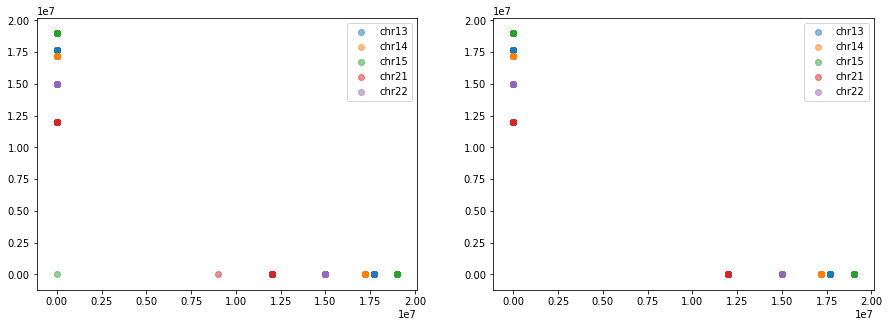

In [281]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
for i, chrom in enumerate(acrocentric_chroms):
    plt.scatter(acrocentric_ibd[:, i, 0, 0], acrocentric_ibd[:, i, 0, 1], alpha=0.5, label=chrom)

plt.legend()

plt.subplot(1, 2, 2)
for i, chrom in enumerate(acrocentric_chroms):
    plt.scatter(acrocentric_ibd[:, i, 1, 0], acrocentric_ibd[:, i, 1, 1], alpha=0.5, label=chrom)

    
plt.legend()
plt.show()

In [286]:
combos = list(combinations(np.arange(len(acrocentric_chroms)), r=2))

def look_for_relationship(i, is_pat, label):
    f = is_aff_aff
    same_affaff = np.sum(acrocentric_ibd[f, i, is_pat, 1]/np.sum(acrocentric_ibd[f, i, is_pat, :], axis=1) > 0.5)
    different_affaff = np.sum(acrocentric_ibd[f, i, is_pat, 1]/np.sum(acrocentric_ibd[f, i, is_pat, :], axis=1) < 0.5)
    
    f = is_aff_nt
    same_affnt = np.sum(acrocentric_ibd[f, i, is_pat, 1]/np.sum(acrocentric_ibd[f, i, is_pat, :], axis=1) > 0.5)
    different_affnt = np.sum(acrocentric_ibd[f, i, is_pat, 1]/np.sum(acrocentric_ibd[f, i, is_pat, :], axis=1) < 0.5)
    
    
    #pvalue = stats.binom_test(same, same+different)
    c = [[same_affaff, different_affaff],
         [same_affnt, different_affnt]]
    pvalue = stats.chi2_contingency(c)[1]
    if pvalue < 0.05/len(combos):
        print(label, acrocentric_chroms[i], pvalue, c)
    

for i, chrom in enumerate(acrocentric_chroms):
    
    look_for_relationship(i, 0, 'mat')
    look_for_relationship(i, 1, 'pat')
    
    f = is_aff_aff
    same_affaff = np.sum(np.sum(acrocentric_ibd[f, i, :, 1], axis=1)/np.sum(acrocentric_ibd[f, i, :, :], axis=(1, 2)) > 0.5)
    different_affaff = np.sum(np.sum(acrocentric_ibd[f, i, :, 1], axis=1)/np.sum(acrocentric_ibd[f, i, :, :], axis=(1, 2)) < 0.5)
    
    f = is_aff_nt
    same_affnt = np.sum(np.sum(acrocentric_ibd[f, i, :, 1], axis=1)/np.sum(acrocentric_ibd[f, i, :, :], axis=(1, 2)) > 0.5)
    different_affnt = np.sum(np.sum(acrocentric_ibd[f, i, :, 1], axis=1)/np.sum(acrocentric_ibd[f, i, :, :], axis=(1, 2)) < 0.5)
    
    
    #pvalue = stats.binom_test(same, same+different)
    c = [[same_affaff, different_affaff],
         [same_affnt, different_affnt]]
    pvalue = stats.chi2_contingency(c)[1]
    if pvalue < 0.05/len(combos):
        print('both', acrocentric_chroms[i], pvalue, c)
    
    

//anaconda3/lib/python3.7/site-packages/ipykernel/__main__.py:9: RuntimeWarning: invalid value encountered in true_divide
//anaconda3/lib/python3.7/site-packages/ipykernel/__main__.py:9: RuntimeWarning: invalid value encountered in greater
//anaconda3/lib/python3.7/site-packages/ipykernel/__main__.py:10: RuntimeWarning: invalid value encountered in true_divide
//anaconda3/lib/python3.7/site-packages/ipykernel/__main__.py:10: RuntimeWarning: invalid value encountered in less


In [289]:
combos = list(combinations(np.arange(len(acrocentric_chroms)), r=2))

def look_for_relationship(i, j, is_pat, label):
    f = is_aff_aff | is_nt_nt
    ibd_ibd_affaff = np.sum((acrocentric_ibd[f, i, is_pat, 1]/np.sum(acrocentric_ibd[f, i, is_pat, :], axis=1) > 0.5) & \
                (acrocentric_ibd[f, j, is_pat, 1]/np.sum(acrocentric_ibd[f, j, is_pat, :], axis=1) > 0.5))
    noibd_noibd_affaff = np.sum((acrocentric_ibd[f, i, is_pat, 1]/np.sum(acrocentric_ibd[f, i, is_pat, :], axis=1) < 0.5) & \
                (acrocentric_ibd[f, j, is_pat, 1]/np.sum(acrocentric_ibd[f, j, is_pat, :], axis=1) < 0.5))
    noibd_ibd_affaff = np.sum((acrocentric_ibd[f, i, is_pat, 1]/np.sum(acrocentric_ibd[f, i, is_pat, :], axis=1) < 0.5) & \
                (acrocentric_ibd[f, j, is_pat, 1]/np.sum(acrocentric_ibd[f, j, is_pat, :], axis=1) > 0.5))
    ibd_noibd_affaff = np.sum((acrocentric_ibd[f, i, is_pat, 1]/np.sum(acrocentric_ibd[f, i, is_pat, :], axis=1) > 0.5) & \
                (acrocentric_ibd[f, j, is_pat, 1]/np.sum(acrocentric_ibd[f, j, is_pat, :], axis=1) < 0.5))
    
    f = is_aff_nt
    ibd_ibd_affnt = np.sum((acrocentric_ibd[f, i, is_pat, 1]/np.sum(acrocentric_ibd[f, i, is_pat, :], axis=1) > 0.5) & \
                (acrocentric_ibd[f, j, is_pat, 1]/np.sum(acrocentric_ibd[f, j, is_pat, :], axis=1) > 0.5))
    noibd_noibd_affnt = np.sum((acrocentric_ibd[f, i, is_pat, 1]/np.sum(acrocentric_ibd[f, i, is_pat, :], axis=1) < 0.5) & \
                (acrocentric_ibd[f, j, is_pat, 1]/np.sum(acrocentric_ibd[f, j, is_pat, :], axis=1) < 0.5))
    noibd_ibd_affnt = np.sum((acrocentric_ibd[f, i, is_pat, 1]/np.sum(acrocentric_ibd[f, i, is_pat, :], axis=1) < 0.5) & \
                (acrocentric_ibd[f, j, is_pat, 1]/np.sum(acrocentric_ibd[f, j, is_pat, :], axis=1) > 0.5))
    ibd_noibd_affnt = np.sum((acrocentric_ibd[f, i, is_pat, 1]/np.sum(acrocentric_ibd[f, i, is_pat, :], axis=1) > 0.5) & \
                (acrocentric_ibd[f, j, is_pat, 1]/np.sum(acrocentric_ibd[f, j, is_pat, :], axis=1) < 0.5))
    
    
    #pvalue = stats.binom_test(same, same+different)
    c = [[ibd_ibd_affaff, noibd_noibd_affaff, noibd_ibd_affaff, ibd_noibd_affaff],
         [ibd_ibd_affnt, noibd_noibd_affnt, noibd_ibd_affnt, ibd_noibd_affnt]]
    pvalue = stats.chi2_contingency(c)[1]
    if pvalue < 0.05/len(combos):
        print(label, acrocentric_chroms[i], acrocentric_chroms[j], pvalue, c)
    

for i, j in combos:
    
    look_for_relationship(i, j, 0, 'mat')
    look_for_relationship(i, j, 1, 'pat')
    
    

//anaconda3/lib/python3.7/site-packages/ipykernel/__main__.py:16: RuntimeWarning: invalid value encountered in true_divide
//anaconda3/lib/python3.7/site-packages/ipykernel/__main__.py:16: RuntimeWarning: invalid value encountered in greater
//anaconda3/lib/python3.7/site-packages/ipykernel/__main__.py:18: RuntimeWarning: invalid value encountered in true_divide
//anaconda3/lib/python3.7/site-packages/ipykernel/__main__.py:18: RuntimeWarning: invalid value encountered in less
//anaconda3/lib/python3.7/site-packages/ipykernel/__main__.py:20: RuntimeWarning: invalid value encountered in true_divide
//anaconda3/lib/python3.7/site-packages/ipykernel/__main__.py:20: RuntimeWarning: invalid value encountered in greater
//anaconda3/lib/python3.7/site-packages/ipykernel/__main__.py:22: RuntimeWarning: invalid value encountered in true_divide
//anaconda3/lib/python3.7/site-packages/ipykernel/__main__.py:22: RuntimeWarning: invalid value encountered in less
//anaconda3/lib/python3.7/site-package